In [1]:
#%% Packages
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

# %% Data Import
data = sns.load_dataset("flights")
print(f'Number of Entries: {len(data)}')
data.head()


Number of Entries: 144


,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


<Axes: >

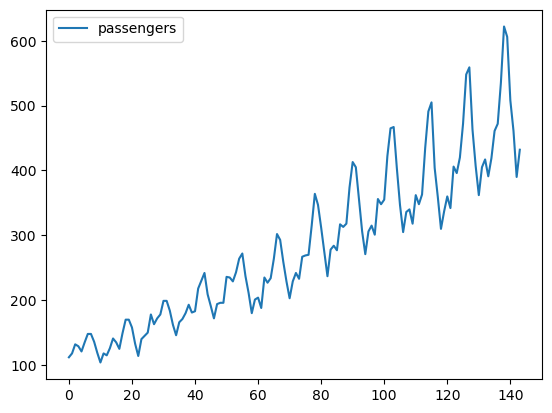

In [11]:
sns.lineplot(data=[data.index, data.passengers])

In [ ]:

# %%
# Convert passenter data to float32 for PyTorch
from numpy import dtype
from sklearn.model_selection import train_test_split


num_points = len(data)
Xy = data.passengers.values

#%% scale the data
scaler = MinMaxScaler(dtype=np.float32)  

Xy_scaled = scaler.fit_transform(Xy.reshape(-1, 1))

split_index = min(data[data.year == max(data.year)].index)
window_size = 12

# %% Data Restructuring
X_restr = []
y_restr = []
for i in range(window_size,len(Xy)):
    X_restr.append(Xy[i-window_size:i])
    y_restr.append(Xy[i])

split_index = split_index-window_size
X_train = X_restr[:split_index]
y_train = y_restr[:split_index]
X_test = X_restr[split_index:]
y_test = y_restr[split_index:]

class FlightData(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = torch.tensor(x, dtype=torch.float32).reshape(-1, window_size, 1)
        self.y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]


train_dataset = FlightData(X_train, y_train)
test_dataset = FlightData(X_test, y_test)


train_loader = DataLoader(train_dataset, batch_size=2 )
test_loader = DataLoader(test_dataset, batch_size=len(y_test) )




In [52]:
ts = torch.tensor(X_train, dtype=torch.float32).reshape(-1, window_size, 1)

In [ ]:

ts[:, -1, :].shape

torch.Size([120, 1])

147163.375
146110.421875
145297.34375
144044.875
143142.59375
142273.28125
141420.015625
140576.140625
139738.5625
138905.75
138076.828125
137251.390625
136429.203125
135610.125
134794.078125
133981.015625
133170.90625
132363.75
131559.59375
130758.359375
129960.078125
129164.75
128372.40625
127582.9375
126796.4375
126012.921875
125232.328125
124454.671875
123679.984375
122908.1875
122139.375
121373.59375
120610.703125
119850.796875
119093.8671875
118339.8671875
117588.765625
116840.671875
116095.5
115353.359375
114614.1328125
113877.875
113144.578125
112414.25
111686.84375
110962.375
110240.9375
109522.4375
108806.890625
108094.3046875
107384.703125
106678.0859375
105974.40625
105273.7421875
104576.0
103881.2734375
103189.4453125
102500.640625
101814.78125
101131.921875
100451.9921875
99775.0
99101.109375
98430.140625
97762.1484375
97097.203125
96435.03125
95775.9609375
95119.9140625
94466.7890625
93816.625
93169.53125
92525.2890625
91884.265625
91246.140625
90610.953125
89978.6953125

<Axes: >

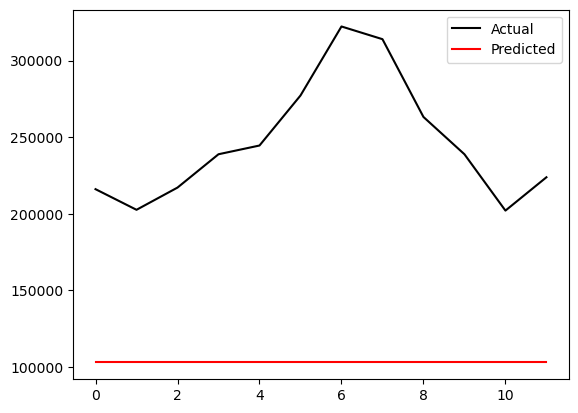

In [ ]:


from calendar import EPOCH
from turtle import forward


class FlightModel(nn.Module):
    def __init__(self, input_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, 5, batch_first=True)
        # self.ac1 = nn.ReLU()
        self.ff = nn.Linear(5,1)
        # self.ac2 = nn.ReLU()

    def forward(self, x):
        x, status = self.lstm(x)
        x = x[:,-1,:]
        # x = self.ac1(x)
        x = self.ff(x)
        # x = self.ac2(x)
        return x


# %% Model, Loss and Optimizer
model = FlightModel()

loss_fun = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
NUM_EPOCHS = 2000

losses = []
#%% Train
for ep in range(NUM_EPOCHS):
    for batch, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch)
        loss = loss_fun(y_pred, batch_y )        
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    if ep % 10 == 0:
        print(loss.item())  # should ve been average




X_test_torch, y_test_torch = next(iter(test_loader))
with torch.no_grad():
    y_pred = model(X_test_torch).numpy()

# both are still in scaled space -> inverse transform
y_act_scaled  = y_test_torch.numpy()
y_pred_scaled = y_pred

y_act  = scaler.inverse_transform(y_act_scaled.reshape(-1, 1)).squeeze()
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).squeeze()

x_act = range(y_act.shape[0])

sns.lineplot(x=x_act, y=y_act,  label='Actual',    color='black')
sns.lineplot(x=x_act, y=y_pred, label='Predicted', color='red')


<Axes: >

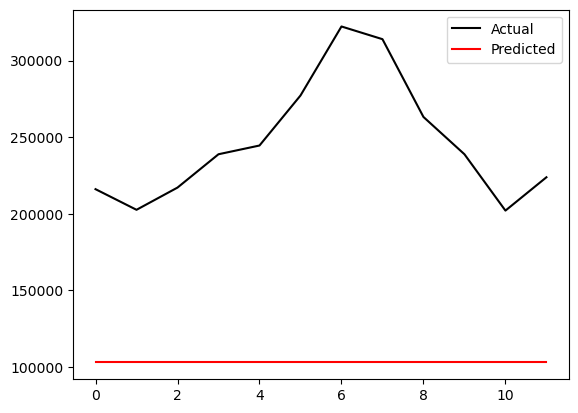

In [74]:
X_test_torch, y_test_torch = next(iter(test_loader))
with torch.no_grad():
    y_pred = model(X_test_torch).numpy()

# both are still in scaled space -> inverse transform
y_act_scaled  = y_test_torch.numpy()
y_pred_scaled = y_pred

y_act  = scaler.inverse_transform(y_act_scaled.reshape(-1, 1)).squeeze()
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).squeeze()

x_act = range(y_act.shape[0])

sns.lineplot(x=x_act, y=y_act,  label='Actual',    color='black')
sns.lineplot(x=x_act, y=y_pred, label='Predicted', color='red')


In [ ]:
model.eval()

array([216110., 202642., 217146., 238902., 244600., 277234., 322300.,
       314012., 263248., 238902., 202124., 223880.], dtype=float32)

In [4]:
probs = np.array([0, 0.1, 0.3, 0.6])
probs = probs[probs > 0]
print(-(probs * np.log2(probs)).sum())
def entr(p):
    res = 0
    for pv in p:
        res -= pv*np.log2(pv)
    return res

entr(probs)

1.295461844238322


1.295461844238322